In [1]:
# Import necessary libraries
import pyswmm  # Library for working with SWMM (Storm Water Management Model)
import pandas as pd  # Data manipulation and analysis library
import numpy as np  # Numerical operations library
import matplotlib  # Comprehensive library for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt  # Matplotlib's pyplot interface for plotting
import pathlib  # Object-oriented filesystem paths
import swmmio

# Set font properties for matplotlib
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)  # Apply font settings to matplotlib
matplotlib.rcParams['figure.dpi'] = 600  # Set the resolution of the figure
matplotlib.rcParams["mathtext.fontset"] = "dejavuserif"  # Set the font for math text
matplotlib.rcParams['text.usetex'] = False  # Disable the use of LaTeX for text rendering

### Load Results

In [2]:
# Define the directoryectory path to the 'Networks' folder
directory = pathlib.Path.cwd().parent.parent / 'Networks'
network = 'Modena'

# Read the CSV files containing computation time and continuity errors
comps = pd.read_csv(directory / (network+'/Continuity and Computational Cost Files/Comp_times_solspeed_Final.csv'))
conts = pd.read_csv(directory /(network+'/Continuity and Computational Cost Files/Continuity_Errors_solspeed_Final.csv'))

# Rename the columns for better readability
comps.rename(columns = {comps.columns[0]:'Sol Speed',"10000m":"Original","250m":250, "100m": 100, "50m":50, "25m":25}, inplace=True)
conts.rename(columns = {conts.columns[0]:'Sol Speed',"10000m":"Original","250m":250, "100m": 100, "50m":50, "25m":25}, inplace=True)

# Sort the dataframes by the 'Timestep' column
comps.sort_values('Sol Speed', inplace = True)
conts.sort_values('Sol Speed', inplace = True)  # Fixed missing 'Timestep' argument

# Reset the index to 'Timestep' and drop the old index
comps = comps.reset_index(drop=True).set_index('Sol Speed', drop = True)
conts = conts.reset_index(drop=True).set_index('Sol Speed', drop = True)

# Apply transformations: absolute values for 'conts' and convert 'comps' to minutes
conts = conts.apply(lambda x : abs(x))
comps = comps.apply(lambda x : x/60)  # convert to minutes

# Drop duplicate indices
comps = comps[~comps.index.duplicated(keep='first')]
conts = conts[~conts.index.duplicated(keep='first')]

# Display the first few rows of the 'conts' dataframe
conts.head()

,Original,250,100,50,25
Sol Speed,,,,,
1.000000,2388.401123,3128.652588,8693.897461,20772.32031,42690.273440
1.097844,2388.401123,3128.652588,8693.897461,19400.32227,39722.222660
1.205261,2388.401123,3128.652588,8693.897461,18031.86523,36689.691410
1.323188,2388.401123,3128.652588,8693.897461,16769.11523,3.208338
1.452654,2388.401123,3128.652588,8214.532227,15669.03613,2.683499


### Create linear interpolation functions for all results

In [3]:
from scipy.interpolate import interp1d

cont_interp_original = interp1d(conts.index, conts["Original"], kind='linear')
cont_interp250 = interp1d(conts.index, conts[250], kind='linear')
cont_interp100 = interp1d(conts.index, conts[100], kind='linear')
cont_interp50 = interp1d(conts.index, conts[50], kind='linear')
cont_interp25 = interp1d(conts.index, conts[25], kind='linear')

cont_interp_list = [cont_interp_original, cont_interp250, cont_interp100, cont_interp50, cont_interp25]

comp_interp_original = interp1d(comps.index, comps['Original'], kind='linear')
comp_interp250 = interp1d(comps.index, comps[250], kind='linear')
comp_interp100 = interp1d(comps.index, comps[100], kind='linear')
comp_interp50 = interp1d(comps.index, comps[50], kind='linear')
comp_interp25 = interp1d(comps.index, comps[25], kind='linear')

comp_interp_list = [comp_interp_original, comp_interp250, comp_interp100, comp_interp50, comp_interp25]


**Plot the variable timestep results**

In [4]:
if network == 'Modena':
    vsteps = pd.read_csv('../../Networks/Modena/Continuity and Computational Cost Files/Variable Time Step Results_Final.csv')
    vsteps.drop(columns=['Unnamed: 0'], inplace=True)
    vsteps['Sol Speed'] = pd.read_csv('../../Networks/Modena/Continuity and Computational Cost Files/mean_delta_xs.csv')['Mean_Conduit_Length'] / 1
    vsteps["Execution Time"] = vsteps["Execution Time"].apply(lambda x: x/60)
    vsteps.head()

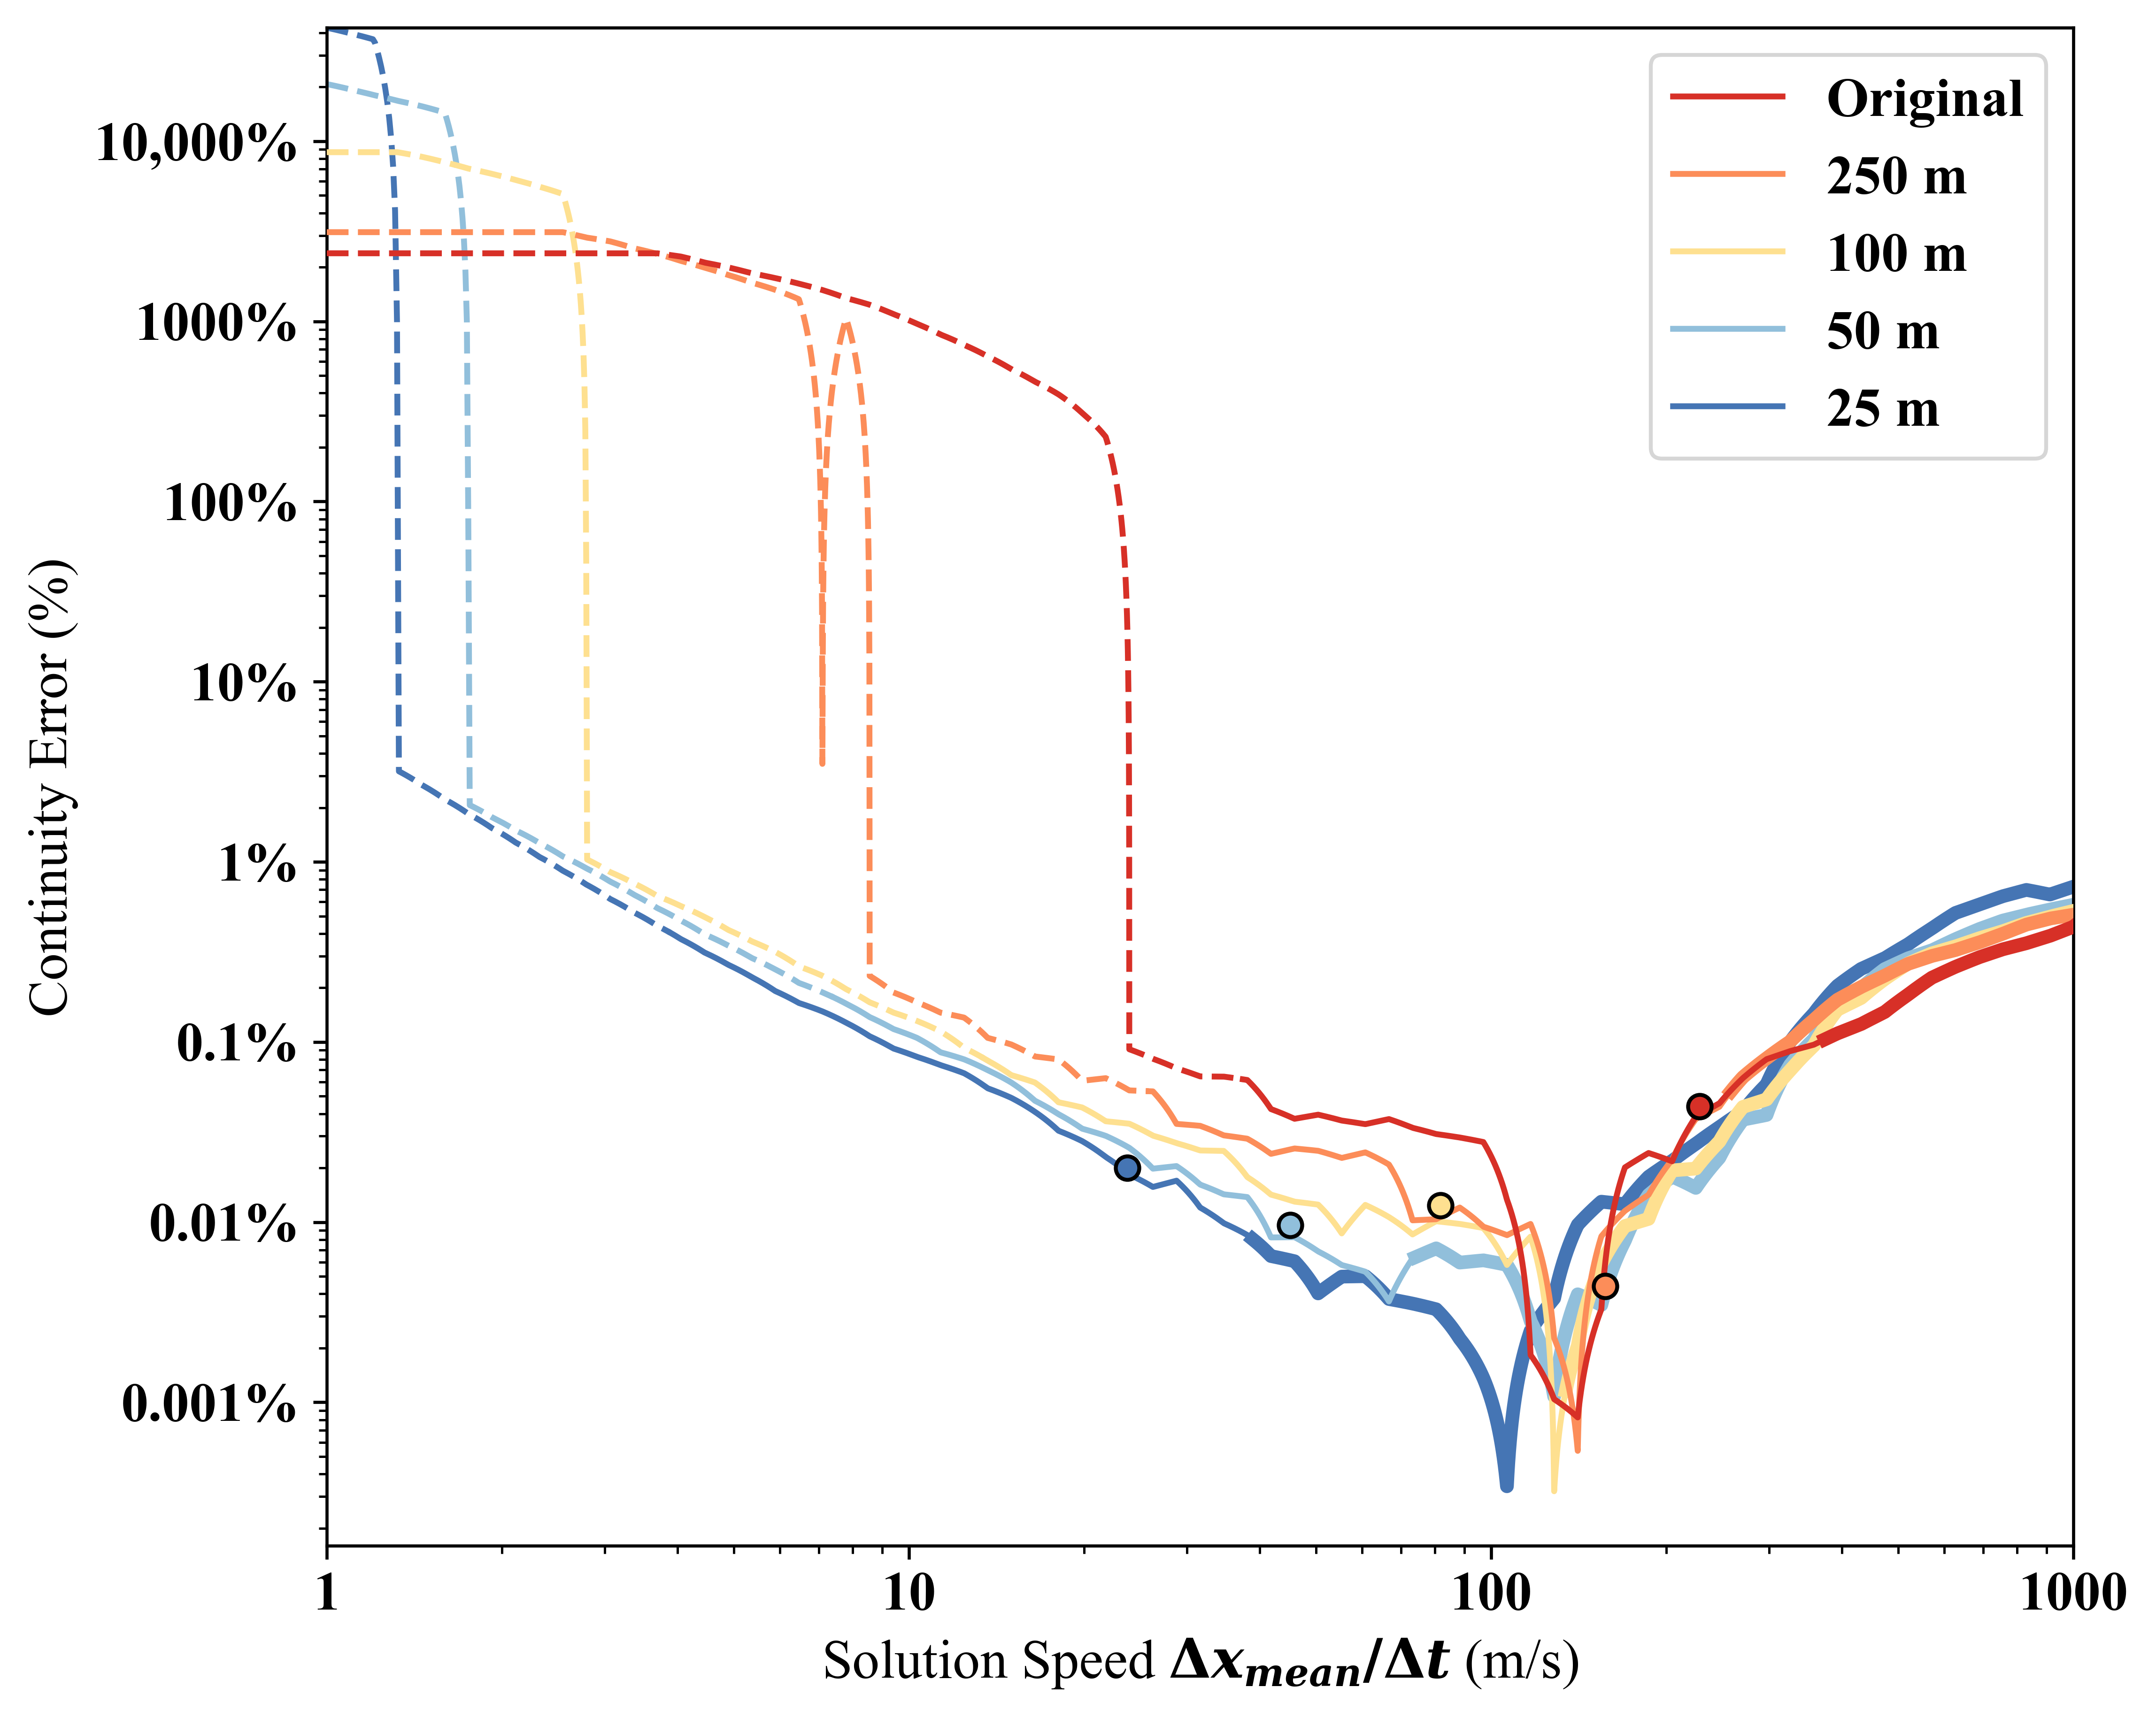

In [6]:
from matplotlib.lines import Line2D
min_lengths = {"Modena": 6.03, "Pescara": 10, "Farina et al (2014)": 9.6}
max_Ds = {"Modena": 0.1, "Pescara": 0.15, "Farina et al (2014)": 0.45}

min_length = min_lengths[network]
max_D = max_Ds[network]
vasconcelos_t_max = 0.1 * min_length / np.sqrt(9.81 * max_D)
roesner_t_max = vasconcelos_t_max * 10

mean_xs = pd.read_csv('../../Networks/'+network+'/Continuity and Computational Cost Files/mean_delta_xs.csv')['Mean_Conduit_Length']
vasconcelos_markers_x = [x / vasconcelos_t_max for x in mean_xs]
roesner_markers_x = [x / roesner_t_max for x in mean_xs]

# Define colors and labels
list_of_colors = ['#d73027', '#fc8d59','#fee090','#91bfdb',"#4575b4"]
labels = ['Original', '250 m', '100 m', '50 m', '25 m']
zorders = [5, 4, 3, 2, 1]

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(8)

ax.set_yscale('log')
ax.set_xscale('log')

interp_list = cont_interp_list

# Plot the data with different linestyles
for i in range(len(vasconcelos_markers_x)):
    x_range = np.arange(interp_list[i].x[0], roesner_markers_x[i], 0.01)
    ax.plot(x_range, interp_list[i](x_range), c=list_of_colors[i], linestyle='--', zorder = zorders[i])
    
    try: 
        x_range = np.arange(roesner_markers_x[i], vasconcelos_markers_x[i], 0.01)
        ax.plot(x_range, interp_list[i](x_range), c=list_of_colors[i], label=labels[i], zorder = zorders[i])
    except: 
        x_range = np.arange(roesner_markers_x[i], interp_list[i].x[-1], 0.01)
        ax.plot(x_range, interp_list[i](x_range), c=list_of_colors[i], label=labels[i], zorder = zorders[i])
    
    try:
        x_range = np.arange(vasconcelos_markers_x[i], interp_list[i].x[-1], 0.01)
        ax.plot(x_range, interp_list[i](x_range), c=list_of_colors[i], lw=3.5, zorder = zorders[i])
    except:
        pass

if network == 'Modena':
    for i in range(len(vsteps['Sol Speed'])):
        ax.scatter(vsteps['Sol Speed'][i], np.abs(vsteps['Continuity Error'][i]), s=36, marker = 'o', edgecolors = 'black', color= list_of_colors[i], zorder = 7)

formatter = plt.LogFormatter(labelOnlyBase=False)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(1, 1000)
ax.set_xticks([1, 10, 100, 1000])
ax.set_yticks([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])
ax.set_ylim(conts.min().min() * 0.5, conts.max().max())
ax.set_yticklabels(["0.001%", "0.01%", "0.1%", "1%", "10%", "100%", "1000%", "10,000%"])
ax.set_ylabel("Continuity Error (%)")
ax.set_xlabel(r"Solution Speed $\Delta x_{mean} / \Delta t$ (m/s)")

# Custom legend handles for different linestyles
custom_legend_handles = [
    Line2D([0], [0], color='gray', linestyle='None', marker = 'o', markeredgecolor = 'black', label=r'Variable $\Delta t$'),
    Line2D([0], [0], color='gray', linestyle='--', label='Neither'),
    Line2D([0], [0], color='gray', linestyle='-', label='Roesner Only'),
    Line2D([0], [0], color='gray', linestyle='-', label='Both', lw = 3.5),
    Line2D([0], [0], color='white', linestyle='-', label='')
]

# Get the existing legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# combined_handles = handles + custom_legend_handles
# combined_labels = labels + [r'Variable $\Delta t$','Neither', 'Roesner only', 'Both','']
ax.legend(handles, labels)

if network == 'Modena':
    plt.savefig('../Figure Files/Figure 5 - Continuity Error vs. Solution Speed in Modena.png')
elif network == 'Pescara':
    plt.savefig('../Figure Files/Figure S13 - Continuity Error vs. Solution Speed in '+network+'.png')
else: 
    plt.savefig('../Figure Files/Figure S12 - Continuity Error vs. Solution Speed in '+network+'.png')
plt.show()

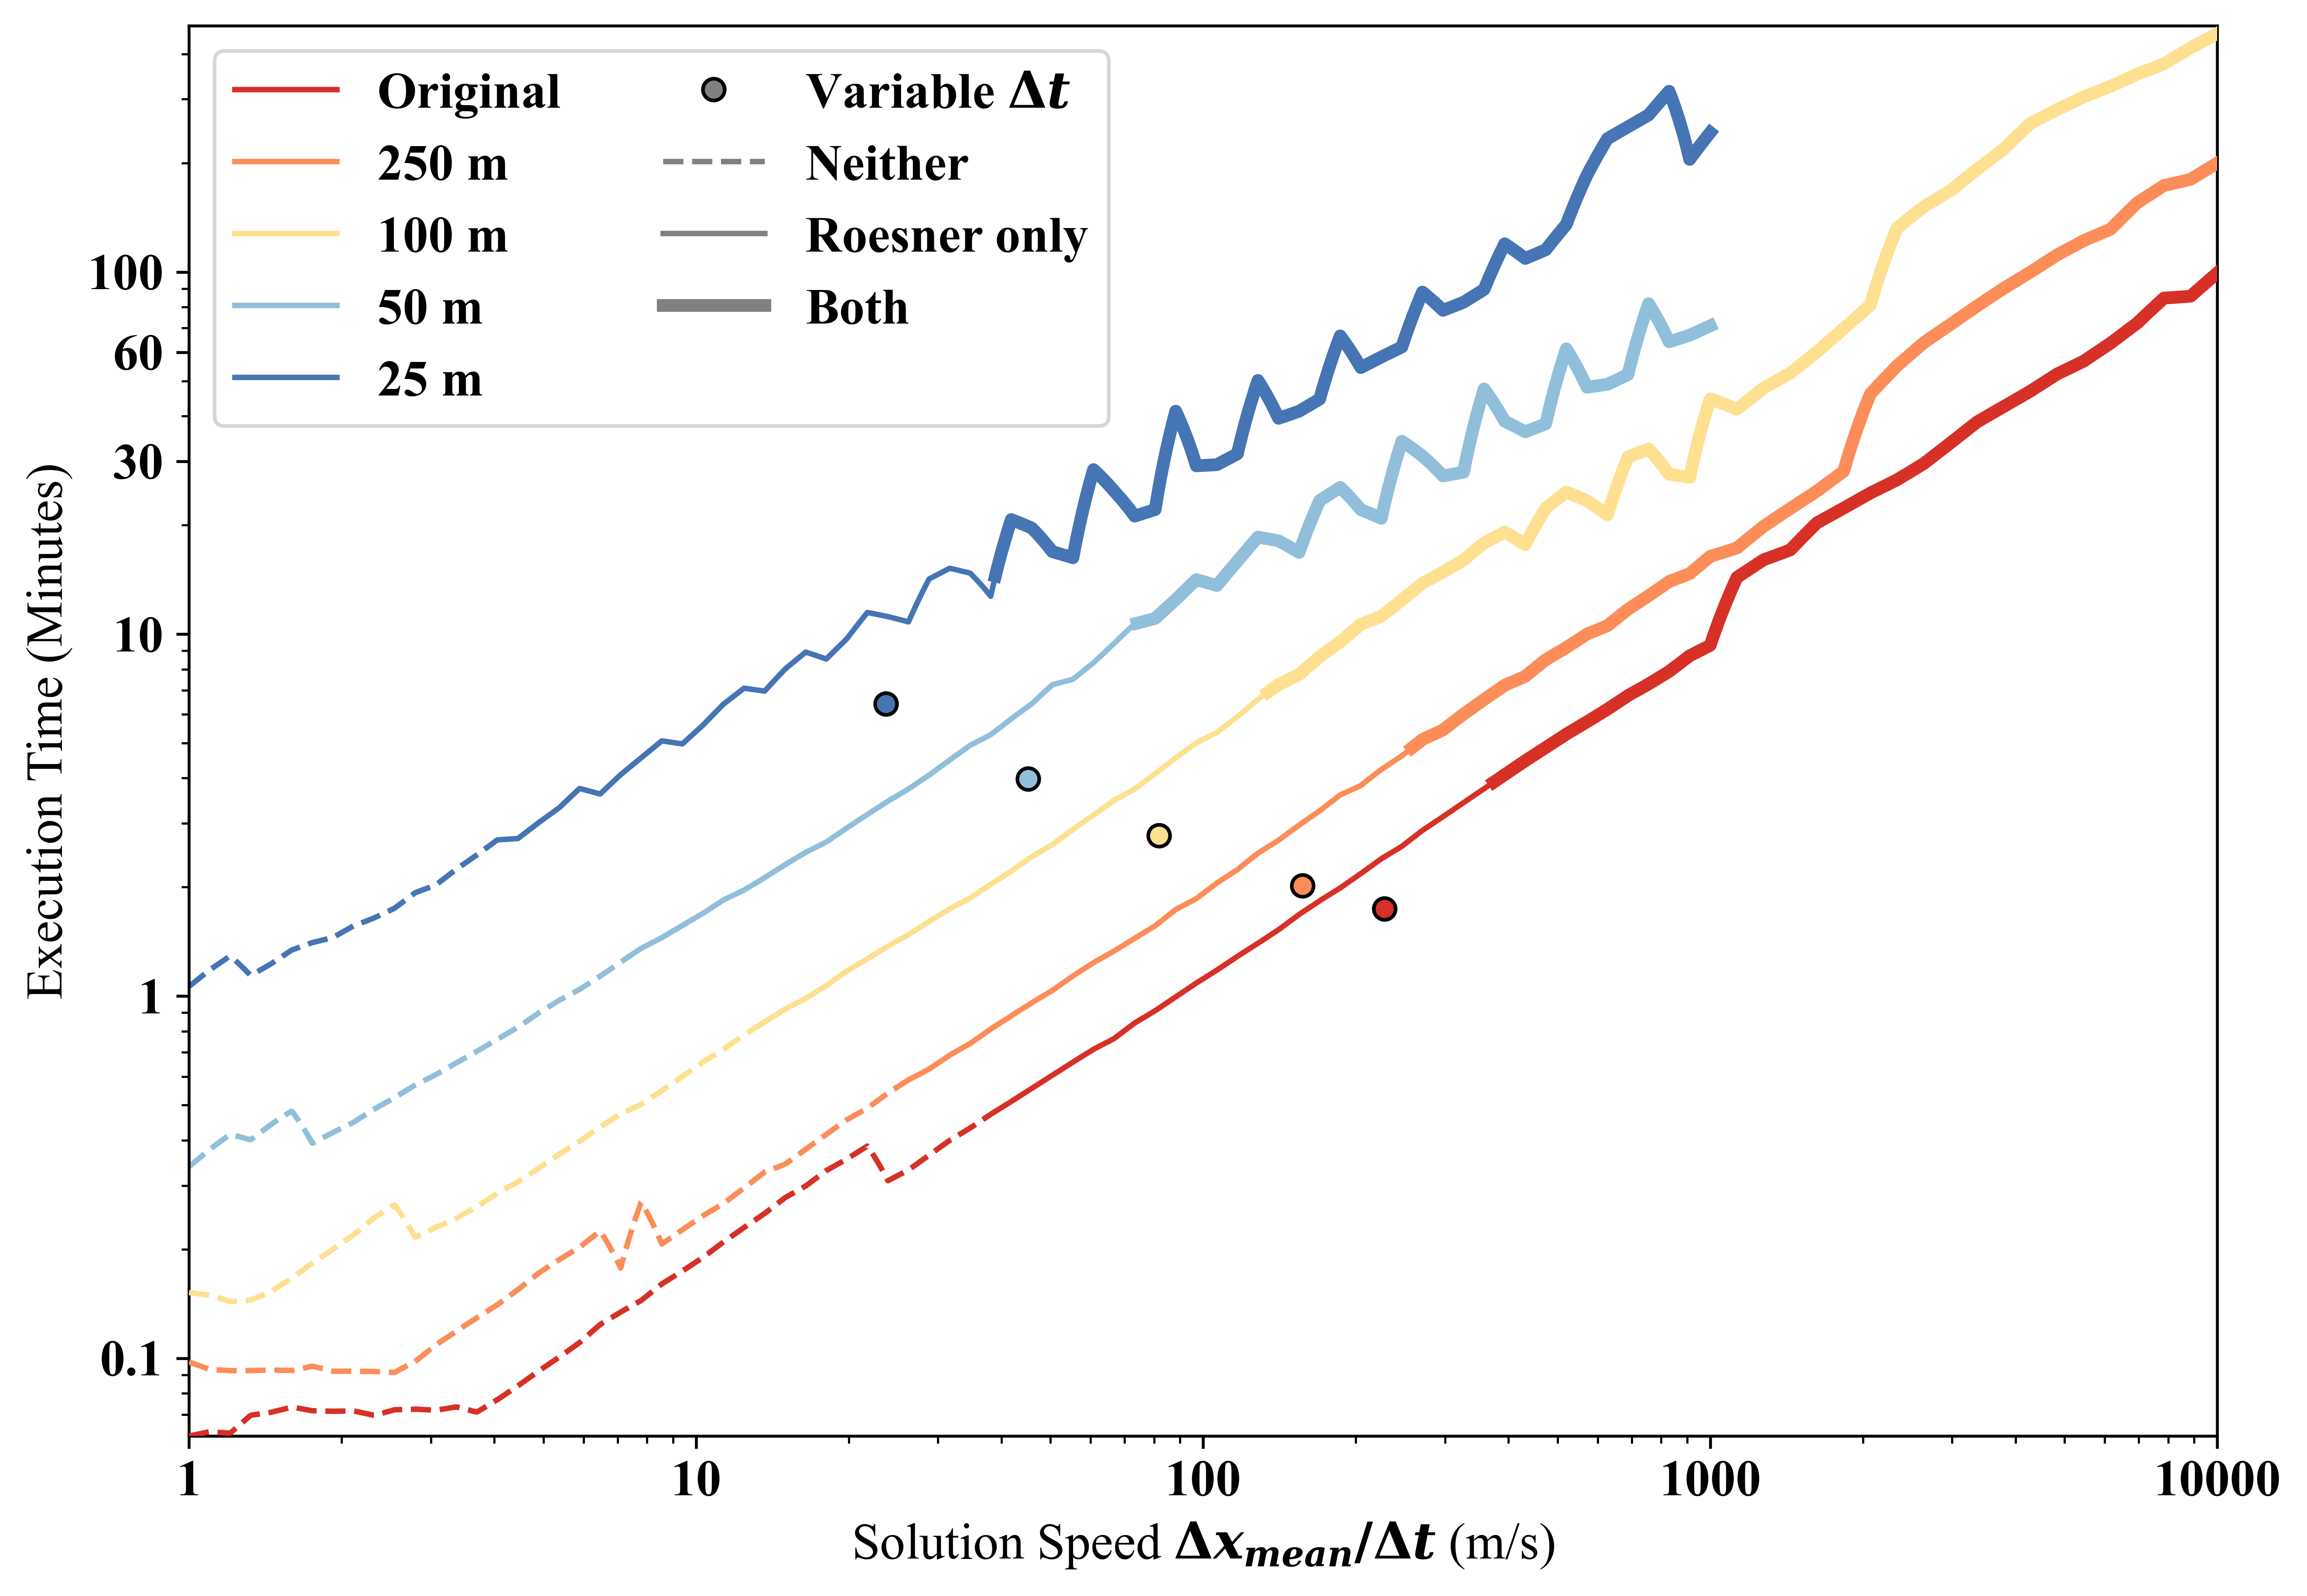

In [7]:
# Define the interpolation functions



interp_list = comp_interp_list


fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.set_yscale('log')
ax.set_xscale('log')


for i in range(len(vasconcelos_markers_x)):
    x_range = np.arange(interp_list[i].x[0], roesner_markers_x[i], 0.01)
    ax.plot(x_range, interp_list[i](x_range), c=list_of_colors[i], linestyle='--', zorder = zorders[i])
    
    try: 
        x_range = np.arange(roesner_markers_x[i], vasconcelos_markers_x[i], 0.01)
        ax.plot(x_range, interp_list[i](x_range), c=list_of_colors[i], label=labels[i], zorder = zorders[i])
    except: 
        x_range = np.arange(roesner_markers_x[i], interp_list[i].x[-1], 0.01)
        ax.plot(x_range, interp_list[i](x_range), c=list_of_colors[i], label=labels[i], zorder = zorders[i])
    
    try:
        x_range = np.arange(vasconcelos_markers_x[i], interp_list[i].x[-1], 0.01)
        ax.plot(x_range, interp_list[i](x_range), c=list_of_colors[i], lw=3.5, zorder = zorders[i])
    except:
        pass


formatter = plt.LogFormatter(labelOnlyBase=False)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(1,10000)
ax.set_xticks([1,10,100, 1000,10000])
# ax.set_xticklabels([0.01,0.1, 1, "10, "10,000"])
ax.set_yticks([0.1,1,10,30,60,100])
ax.set_yticklabels([0.1,1,10,30,60,100])
ax.set_ylim(comps.min().min(),comps.max().max()*1.05)
ax.set_ylabel("Execution Time (Minutes)")
ax.set_xlabel(r"Solution Speed $\Delta x_{mean} / \Delta t$ (m/s)")


if network == 'Modena':
    for i in range(len(vsteps['Sol Speed'])):
        ax.scatter(vsteps['Sol Speed'][i], np.abs(vsteps['Execution Time'][i]), s=36, marker = 'o', edgecolors = 'black', color= list_of_colors[i])


# Get the existing legend handles and labels
handles, labels = ax.get_legend_handles_labels()
combined_handles = handles + custom_legend_handles
combined_labels = labels + [r'Variable $\Delta t$','Neither', 'Roesner only', 'Both','']
ax.legend(combined_handles, combined_labels, ncol=2)
if network == 'Modena':
    plt.savefig('../Figure Files/Figure S14 - Execution Times vs. Solution Speed in Modena.png')
plt.show()

In [8]:
print(r"Time taken to execute 200,000 simulations at Delta x_{max} = v_{sol} = 100 is: ", comp_interp100(100) * 200000 / 60 / 24, "days")

Time taken to execute 200,000 simulations at Delta x_{max} = v_{sol} = 100 is:  710.6773119006998 days


Ratio Statistics:
             250        100        50         25 
count  94.000000  94.000000  75.000000  75.000000
mean    1.664721   3.984297   9.529306  28.656398
std     0.274356   0.835073   2.117987   6.013441
min     1.205853   2.077707   5.477148  16.378619
25%     1.327918   3.333610   8.117282  24.342897
50%     1.734081   4.322227   9.255495  28.205751
75%     1.781717   4.671740  11.396639  32.646071
max     2.157083   5.489167  13.230811  41.453308


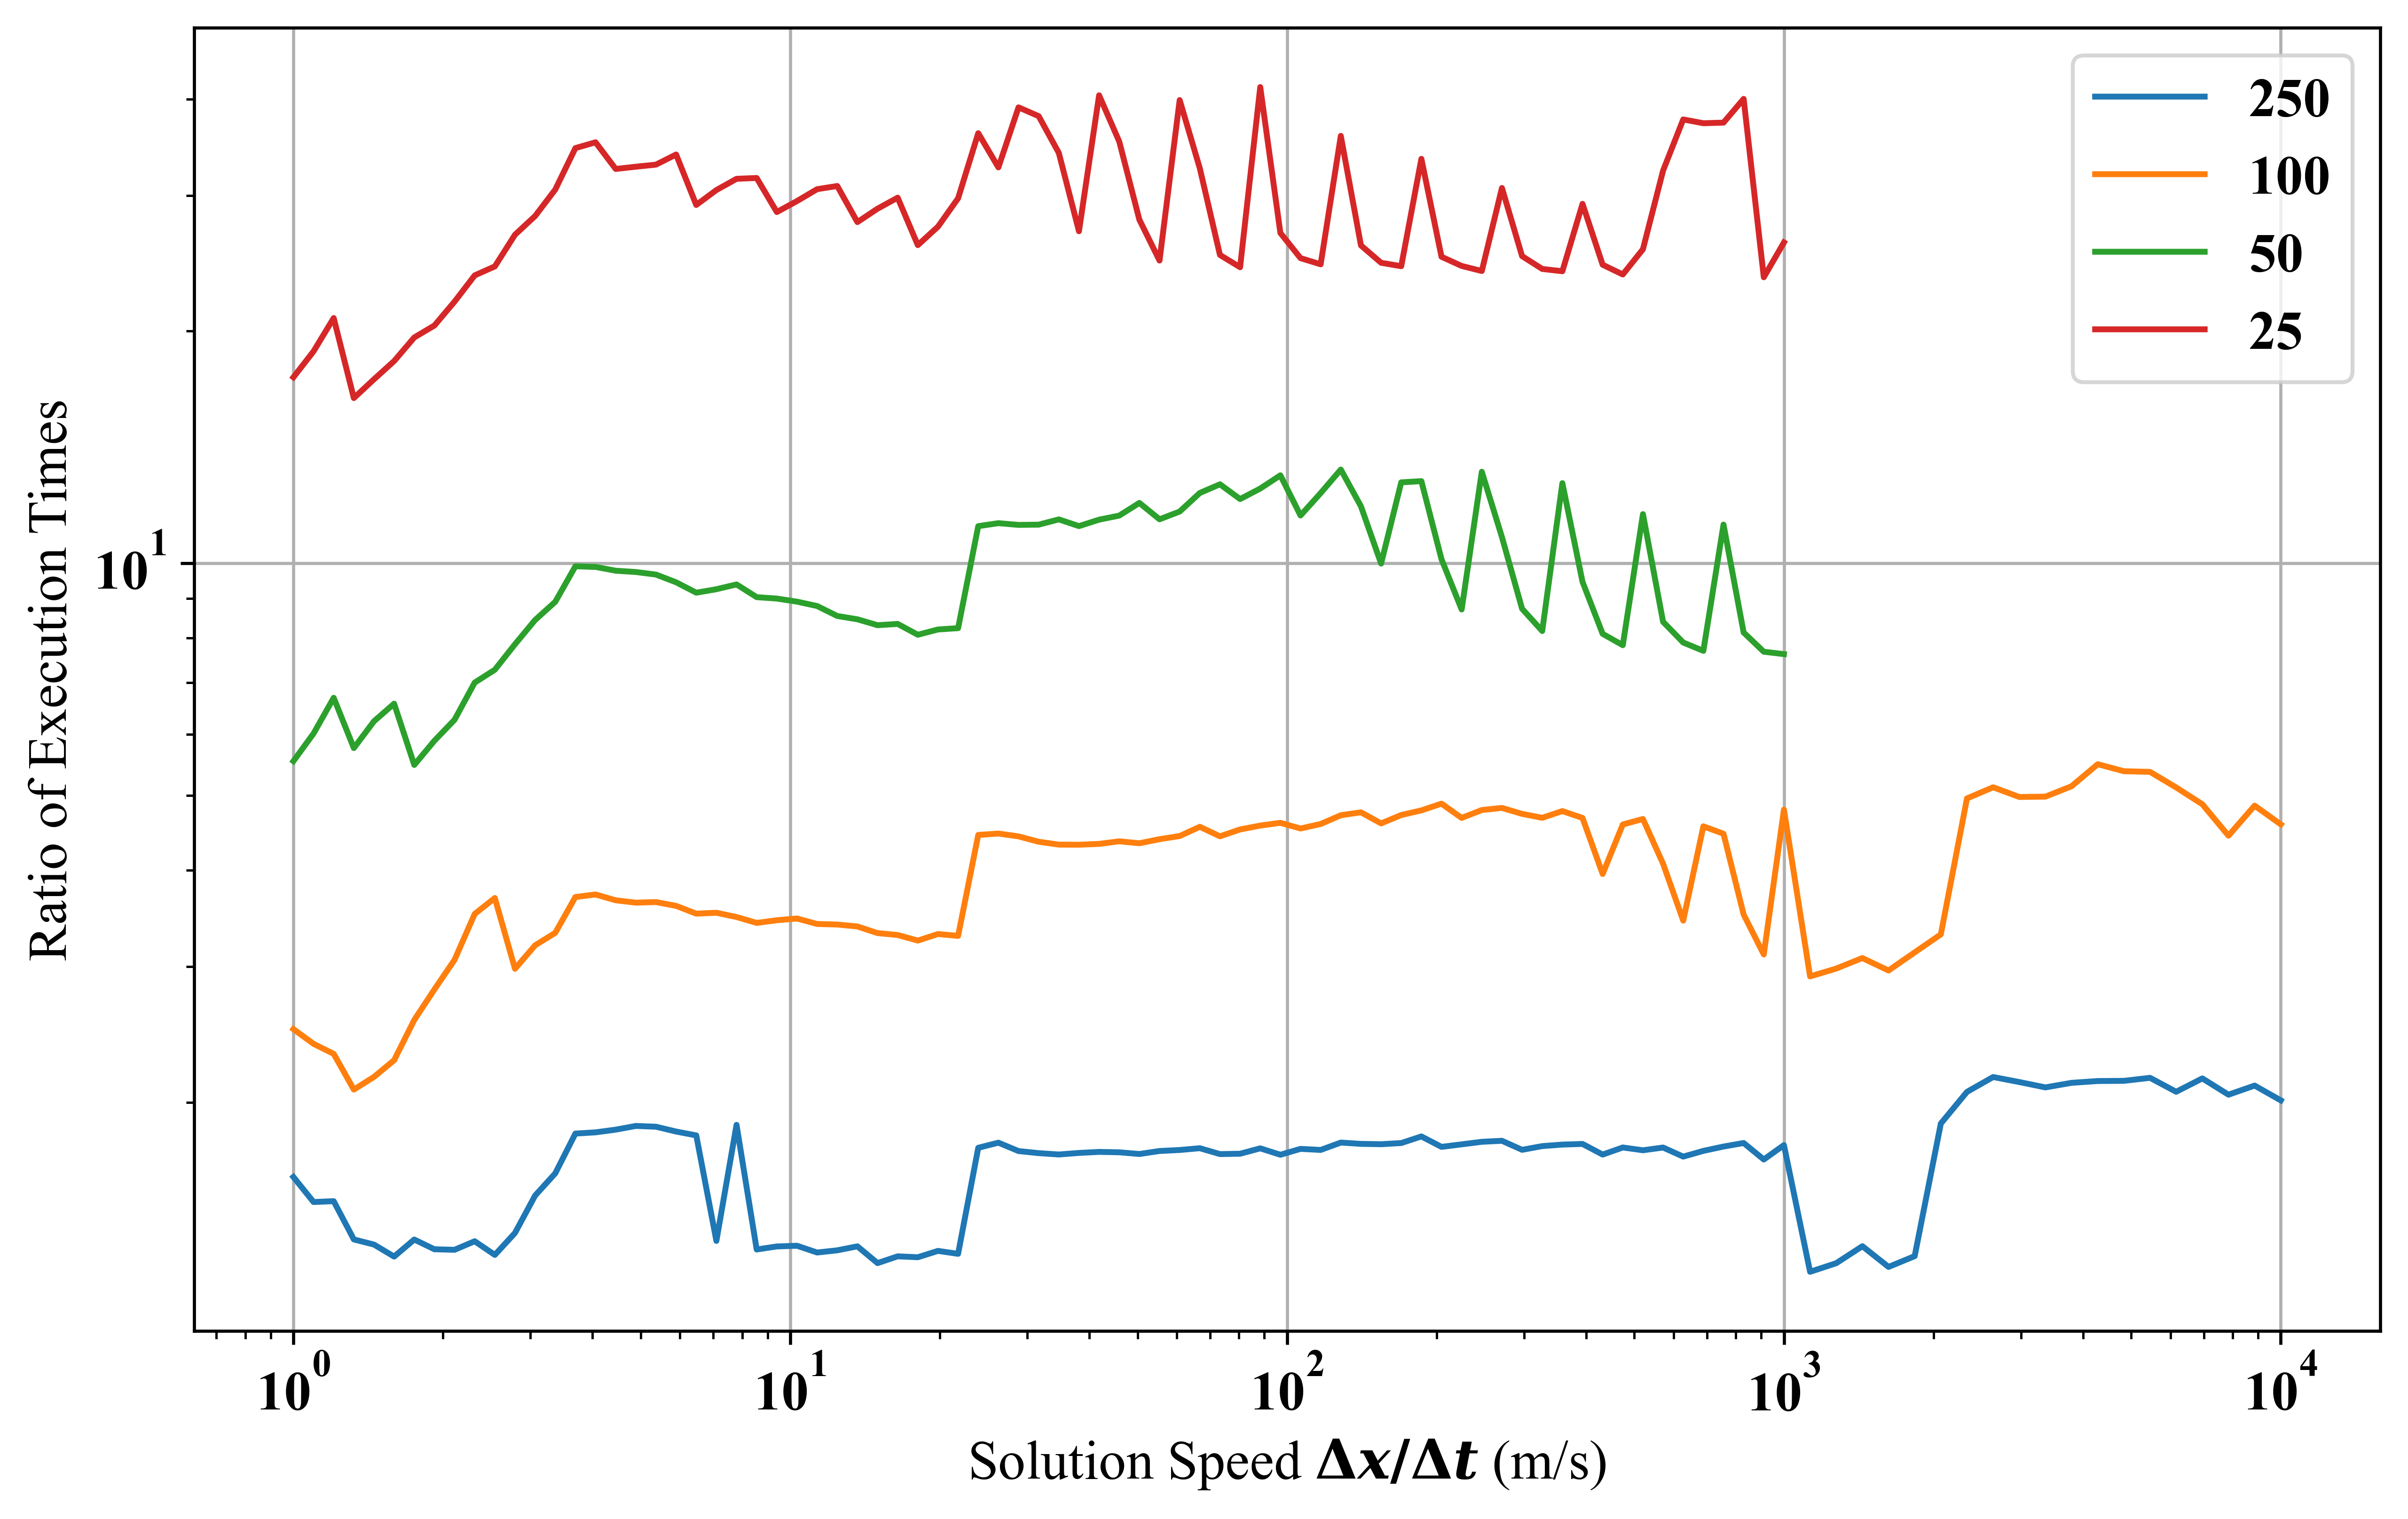

In [9]:
comp_ratio = pd.DataFrame()

for column in comps.columns:
    if column != 'Original':
        comp_ratio[column] = comps[column] / comps['Original']


# Show some basic statistics of the ratios
print("Ratio Statistics:")
print(comp_ratio.describe())

# Plot the ratios
plt.figure(figsize=(10, 6))
for column in comp_ratio.columns:
    plt.plot(comps.index, comp_ratio[column], label=column)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Solution Speed $\Delta x / \Delta t$ (m/s)")
plt.ylabel("Ratio of Execution Times")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
np.logspace(3,0, 75)

array([1000.        ,  910.87641976,  829.69585208,  755.75038724,
        688.39520696,  627.0429615 ,  571.15864781,  520.25494424,
        473.88796097,  431.65336926,  393.18287557,  358.14101001,
        326.22220097,  297.14811047,  270.665207  ,  246.54255471,
        224.56979955,  204.55533501,  186.32463119,  169.71871298,
        154.59277364,  140.81491218,  128.26498305,  116.83354854,
        106.42092441,   96.93631061,   88.29699955,   80.42765483,
         73.25965428,   66.73049161,   60.78323128,   55.36601209,
         50.43159487,   45.93695058,   41.84288508,   38.11369735,
         34.71686819,   31.6227766 ,   28.80444153,   26.23728658,
         23.89892566,   21.76896784,   19.82883949,   18.06162232,
         16.45190588,   14.98565312,   13.65007807,   12.43353424,
         11.32541315,   10.31605178,    9.39664831,    8.55918537,
          7.79636013,    7.1015206 ,    6.46860766,    5.89210219,
          5.36697695,    4.88865275,    4.45295851,    4.05609